In [1]:
%load_ext autoreload
%autoreload 2

import sys
if "../src" not in sys.path:
    sys.path.append("../src")

In [2]:
import copy
from dataclasses import dataclass
from pathlib import Path
from typing import Iterable, Literal

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from IPython.display import display
from tqdm.auto import tqdm


sns.set()

In [3]:
def savefig(name: str, **kwargs):
    kwargs.setdefault("dpi", 200)
    kwargs.setdefault("bbox_inches", "tight")
    kwargs.setdefault("transparent", True)
    plt.savefig(name, **kwargs)


In [302]:
def show_time_stats(
    data: pd.DataFrame,
    groupby: str = "instance",
    col: str = "time_cpu",
    title: str = "",
):
    grouped = data.groupby(groupby)[col]
    std = grouped.std(ddof=1) / grouped.mean()
    p95 = np.percentile(std, 95)
    p99 = np.percentile(std, 99)
    plt.hist(std, bins=20, range=(0, p99))

    stats_text = (
        f"Mean std: {std.mean():.1%}\n"
        f"95-th percentile: {p95:.1%}\n"
        f"99-th percentile: {p99:.1%}\n"
        f"Max std: {std.max():.1%}"
    )
    plt.text(
        0.98,
        0.98,
        stats_text,
        transform=plt.gca().transAxes,
        ha="right",
        va="top",
        ma="left",
    )
    if title:
        plt.title(title)
    plt.tight_layout()


## Large instances

In [255]:
large = pd.read_csv("../instances/random_large/metrics.csv")
large.sort_values(["instance", "run"], inplace=True)
metrics_large = large.drop(["run", "feasible"], axis=1).groupby("instance").min()

(large.groupby("instance").std().drop(["time_cpu", "run"],axis=1) == 0).all()


feasible        True
restarts        True
conflicts       True
decisions       True
propagations    True
dtype: bool

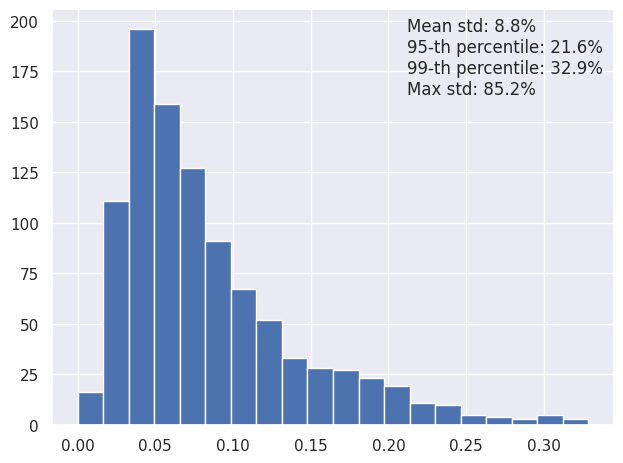

In [306]:
show_time_stats(large)

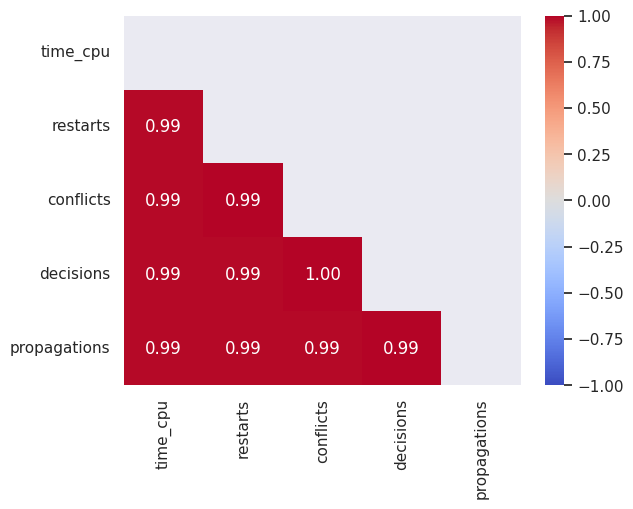

In [257]:
corr = metrics_large.corr("kendall")
corr_mask = np.triu(np.ones(len(corr)))
sns.heatmap(corr, vmin=-1, vmax=1, cmap="coolwarm", annot=True, fmt=".2f", mask=corr_mask)
plt.grid()
savefig("figs/metrics_large_corr.png")

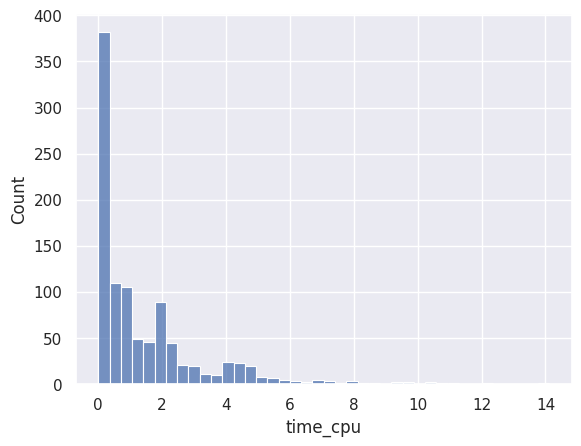

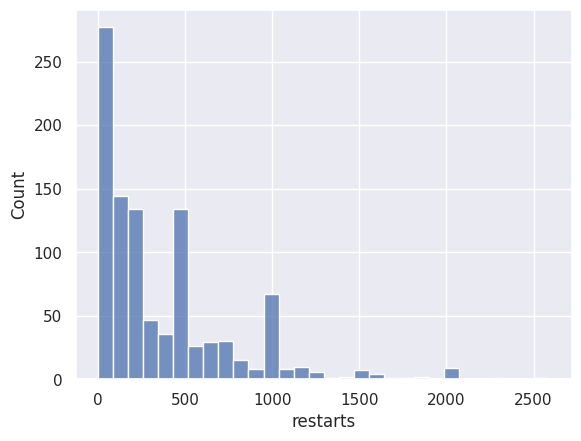

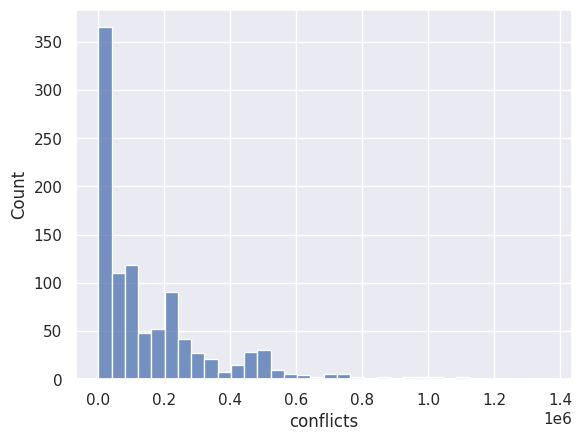

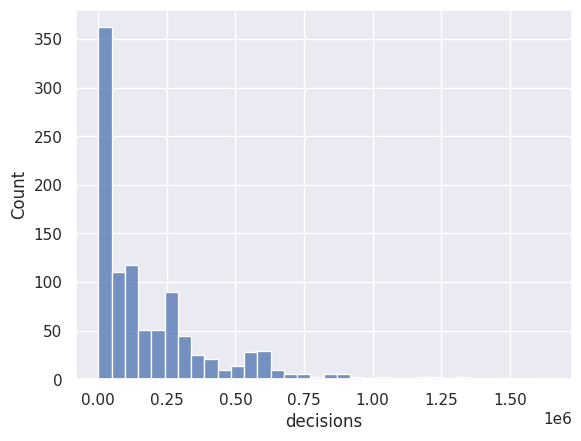

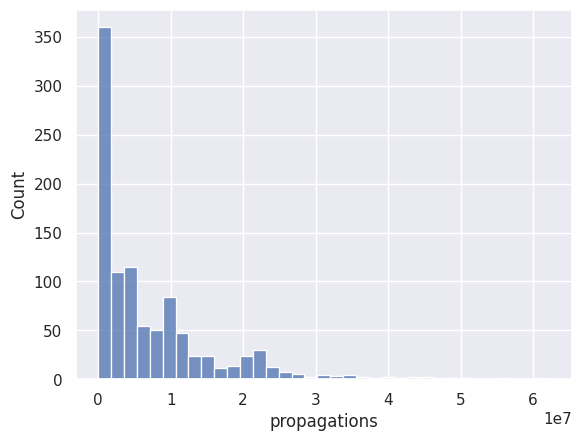

In [258]:
for col in metrics_large.columns:
    sns.histplot(x=col, data=metrics_large)
    plt.show()

/home/fernando/.local/share/virtualenvs/hard_instances-tQ8GgIsG/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


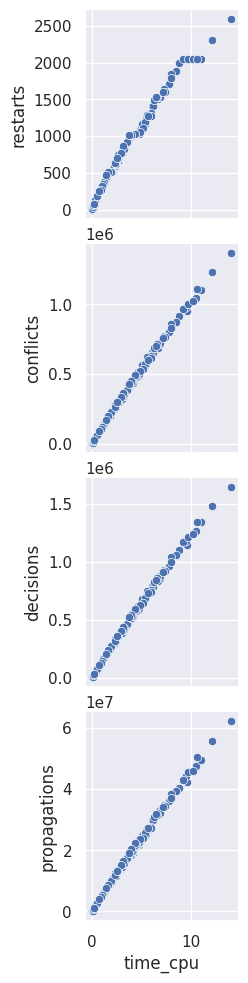

In [259]:
sns.pairplot(data=metrics_large, x_vars="time_cpu", y_vars=["restarts", "conflicts", "decisions", "propagations"])

## Small instances

In [260]:
small = pd.read_csv("../instances/random_small/metrics.csv")
metrics_small = small.drop(["run", "feasible"], axis=1).groupby("instance").min()
(small.groupby("instance").std().drop(["time_cpu", "run"],axis=1) == 0).all()

feasible        True
restarts        True
conflicts       True
decisions       True
propagations    True
dtype: bool

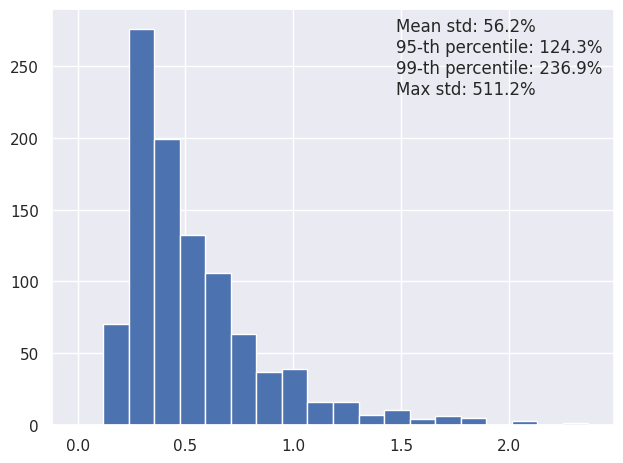

In [307]:
show_time_stats(small)

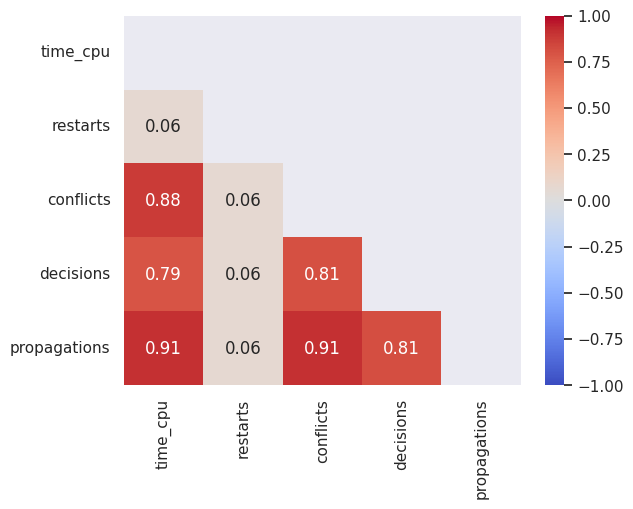

In [138]:
corr = metrics_small.corr("kendall")
corr_mask = np.triu(np.ones(len(corr)))
sns.heatmap(corr, vmin=-1, vmax=1, cmap="coolwarm", annot=True, fmt=".2f", mask=corr_mask)
plt.grid()
savefig("figs/metrics_small_corr.png")

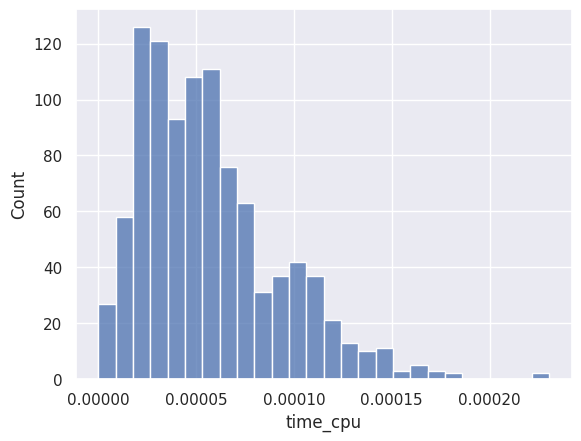

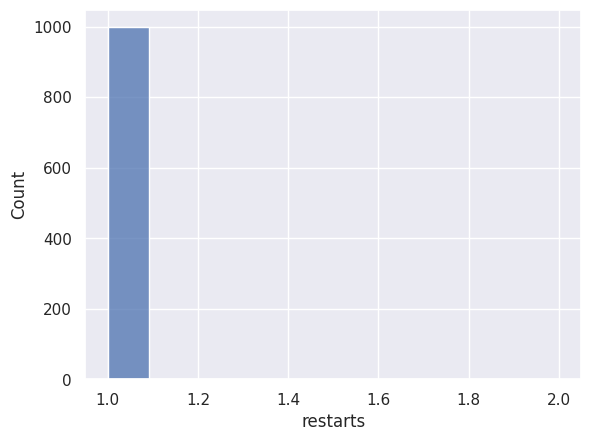

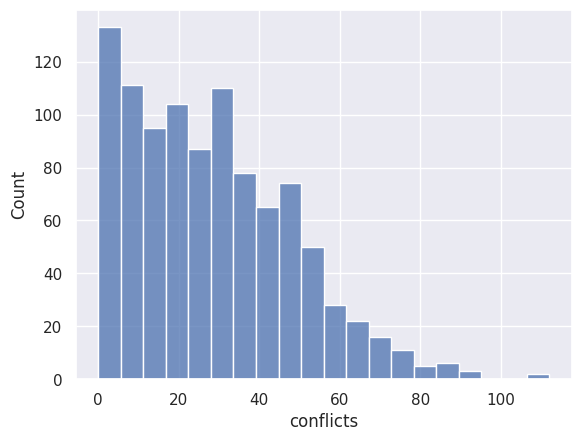

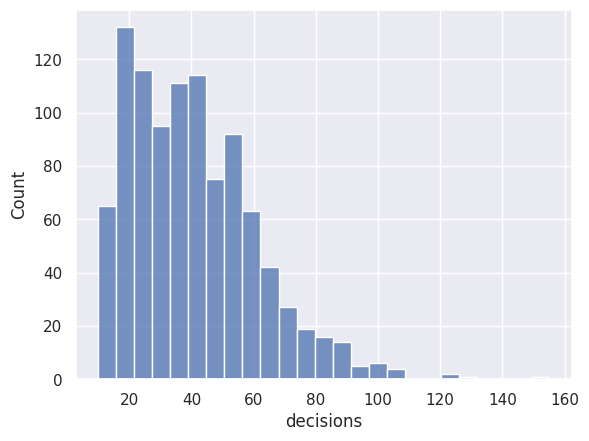

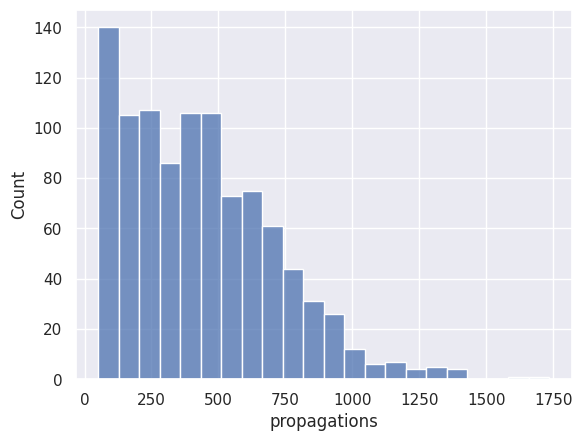

In [262]:
for col in metrics_small.columns:
    sns.histplot(x=col, data=metrics_small)
    plt.show()

/home/fernando/.local/share/virtualenvs/hard_instances-tQ8GgIsG/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


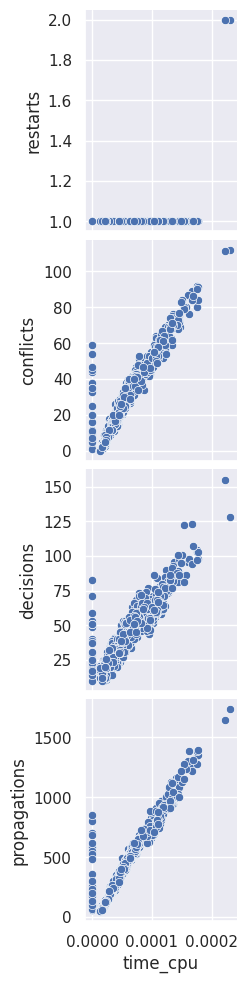

In [263]:
sns.pairplot(data=metrics_small, x_vars="time_cpu", y_vars=["restarts", "conflicts", "decisions", "propagations"])

### Averaging

In [264]:
def get_random_means(
    df: pd.DataFrame,
    group_sizes: int = 3,
    random_state: int = 42,
):
    resampled = df.sample(
        len(df) * group_sizes, replace=True, random_state=random_state
    ).reset_index(drop=True)
    means = resampled.rolling(group_sizes).mean()
    non_overlapping_means = means[group_sizes - 1 :: group_sizes]
    non_overlapping_means.reset_index(drop=True, inplace=True)
    non_overlapping_means.index.name = "group"
    return non_overlapping_means


def resample_and_average_times(
    df: pd.DataFrame, group_sizes: int = 3, random_state: int = 42
):
    return (
        df.groupby("instance", sort=False)
        .apply(
            lambda x: get_random_means(
                x.drop("instance", axis=1),
                group_sizes=group_sizes,
                random_state=random_state,
            )
        )
        .reset_index()
    )


In [315]:
small_means5 = resample_and_average_times(small, group_sizes=5)
small_means10 = resample_and_average_times(small, group_sizes=10)


/tmp/ipykernel_509545/3401824590.py:30: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


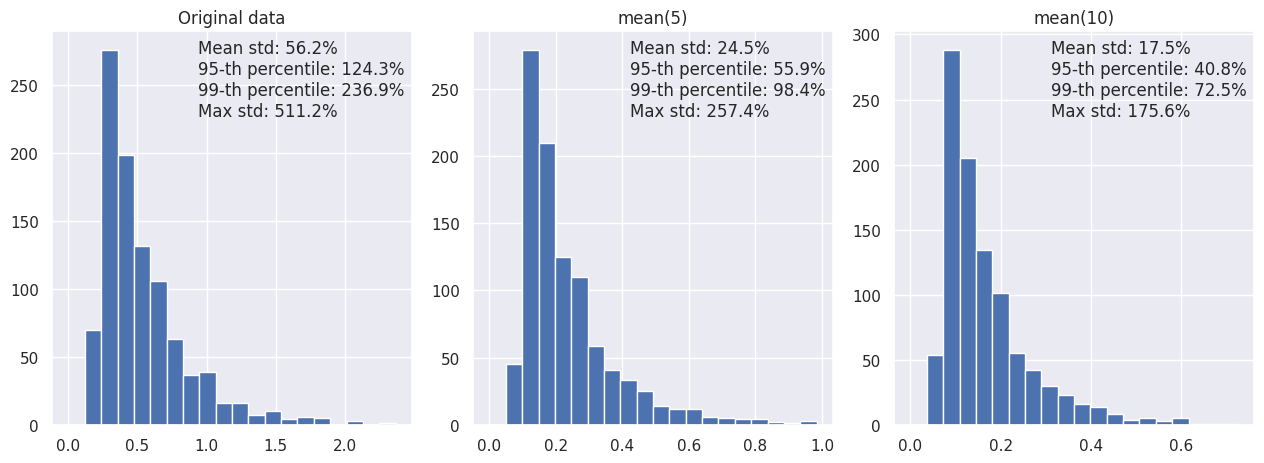

In [317]:
plt.figure(figsize=(12.8, 4.8))

plt.subplot(131)
show_time_stats(small, title="Original data")

plt.subplot(132)
show_time_stats(small_means5, title="mean(5)")

plt.subplot(133)
show_time_stats(small_means10, title="mean(10)")

In [ ]:
def sample_path_length(
    df: pd.DataFrame,
    max_std_rel: 0.3,
):
    resampled = df.sample(
        len(df) * group_sizes, replace=True, random_state=random_state
    ).reset_index(drop=True)
    means = resampled.rolling(group_sizes).mean()
    non_overlapping_means = means[group_sizes - 1 :: group_sizes]
    non_overlapping_means.reset_index(drop=True, inplace=True)
    non_overlapping_means.index.name = "group"
    return non_overlapping_means


def resample_and_average_times(
    df: pd.DataFrame, group_sizes: int = 3, random_state: int = 42
):
    return (
        df.groupby("instance", sort=False)
        .apply(
            lambda x: get_random_means(
                x.drop("instance", axis=1),
                group_sizes=group_sizes,
                random_state=random_state,
            )
        )
        .reset_index()
    )


In [33]:
#!/usr/bin/env python

import argparse
import multiprocessing
from pathlib import Path

import numpy as np
import pandas as pd
from pysat.formula import CNF
from solvers.pysat import PySAT
from tqdm.auto import tqdm, trange


def random_k_sat(
    rng: np.random.Generator,
    n_vars: int,
    n_clauses: int,
    k: int = 3,
) -> CNF:
    variables = rng.choice(1 + np.arange(n_vars), size=(n_clauses, k))
    polarities = rng.choice([1, -1], size=(n_clauses, k))
    literals = variables * polarities
    return CNF(from_clauses=literals.tolist())


def solve(data: tuple[str, int, int]):
    outdir, instance, run = data
    file = outdir + f"/{instance}.cnf"
    cnf = CNF(from_file=file)
    metrics = PySAT("minisat22").solve_instance(cnf)

    return {
        "instance": instance,
        "run": run,
        **metrics,
    }

instance = random_k_sat(np.random.default_rng(), 50, 210)



In [94]:
pd.DataFrame([
    PySAT("g42").solve_instance(instance)
    for _ in range(5)
])

,feasible,time_cpu,restarts,conflicts,decisions,propagations
0,False,0.000173,1,39,47,542
1,False,0.000148,1,39,47,542
2,False,0.000144,1,39,47,542
3,False,0.000148,1,39,47,542
4,False,0.000146,1,39,47,542
